**Кулешов Иван AML-14**

# Домашнее задание «Обучение сверточной сети на практике»

Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

In [2]:
import numpy as np
import pandas as pd

import os

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import re
import glob

import cv2

## Подготовка данных

Для решения используется google.colab в связке с Гугл.Диск. Данные для классификации - файлы train.zip и test.zip необходимо положить на Гугл.Диск в папку dogs-vs-cats

Подключаем Гугл.Диск

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Распаковываем картинки уже в рабочее пространство Колаб

In [4]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/dogs-vs-cats/test.zip')
shutil.unpack_archive('/content/drive/MyDrive/dogs-vs-cats/train.zip')

In [4]:
# Список всех картинок из папки train
train_files = glob.glob('train/*.jpg')

Визуализируем примеры

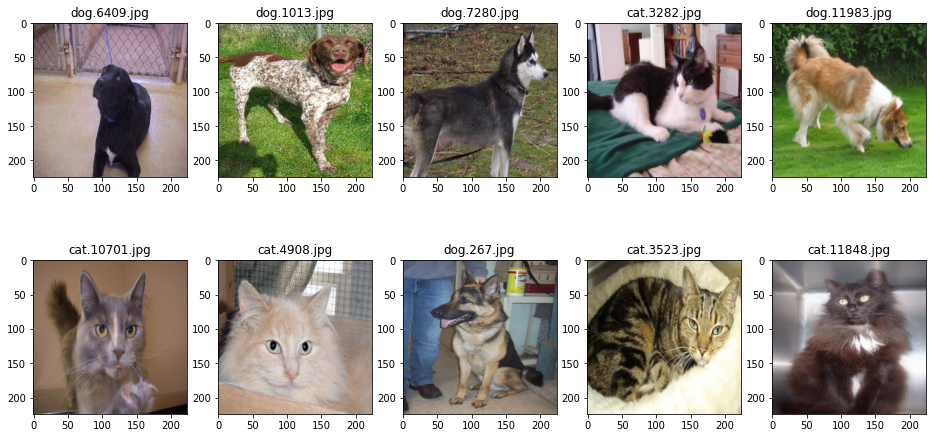

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)

Я буду использовать функцию flow_from_directory, для которой необходимо разнести картинки по разным директориям, которые будут считаться разными классами

In [5]:
# Директории с собачками и кошечками
dog_dir = 'train/dog'
cat_dir = 'train/cat'

# Создаем директории
os.makedirs(dog_dir, exist_ok = True)
os.makedirs(cat_dir, exist_ok = True)

# Перебираем все картинки, в зависимости от ключевого слова - перекладываем в соответствующую папку
for file in train_files:
    file_name = os.path.basename(file)
    if 'cat' in file:
        shutil.move(file, 'train/cat/' + file_name)
    else:
        shutil.move(file, 'train/dog/' + file_name)

## Аугментация данных

Константы модели

In [5]:
BATCH_SIZE = 100 # размер пакета 
IMG_SIZE = (150, 150)  # размер входного изображения сети
TRAIN_DIR = 'train' # папка с картинками, разделенная на классы-поддиректории для функции flow_from_directory

Определяем генератор ImageDataGenerator для аугментации и генераторы загрузки данных пакетами. Разделение на тренировочную и валидационную выборку осуществляется силами генератора ImageDataGenerator, с помощью подвыборки subset

In [7]:
train_datagen = ImageDataGenerator(
                rescale = 1.0 / 255,
                rotation_range = 90,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range = 0.25,
                zoom_range = 0.2,
                horizontal_flip = True,
                vertical_flip = False,
                fill_mode = 'nearest',
                validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
                    TRAIN_DIR,
                    target_size = IMG_SIZE,
                    batch_size = BATCH_SIZE,
                    class_mode = 'binary',
                    subset = "training")

val_generator = train_datagen.flow_from_directory(
                    TRAIN_DIR,
                    target_size = IMG_SIZE,
                    batch_size = BATCH_SIZE,
                    class_mode = 'binary',
                    subset = "validation")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Архитектура модели

In [23]:
from keras import regularizers

reg = 1e-4 # коэффициент регуляризации

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(reg), input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(reg)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(reg)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(reg)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 75, 75, 64)       

In [24]:
# использование обратных вызовов
# filepath='model.{epoch:02d}-{val_loss:.2f}.h5'
# Ранняя остановка - обучение прекращается, если функция потерь на валидации не улучшается 3 эпохи подряд
# сохраняются веса модели - только если потери на валидации уменьшились
# TensorBoard - сохраняются логи для стенда
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_loss.h5',
                                       monitor='val_loss', save_best_only=True,
                                       save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

Компилируем и обучаем модель

In [25]:
EPOCHS = 13 # количество эпох

# Функция потерь для обучения
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model.compile(loss = 'binary_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy']
             )

In [26]:
# model.fit_generator is deprecated, use fit
history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples / BATCH_SIZE, # train_generator.samples = 20000
            epochs = EPOCHS,
            validation_data = val_generator,
            validation_steps = val_generator.samples / BATCH_SIZE, # train_generator.samples = 5000
            callbacks=my_callbacks
            )

Epoch 1/13
200/200 [==============================] - 179s 872ms/step - loss: 0.8275 - accuracy: 0.6316 - val_loss: 0.8007 - val_accuracy: 0.5590
Epoch 2/13
200/200 [==============================] - 174s 868ms/step - loss: 0.6346 - accuracy: 0.6708 - val_loss: 0.6623 - val_accuracy: 0.6336
Epoch 3/13
200/200 [==============================] - 173s 866ms/step - loss: 0.6097 - accuracy: 0.6938 - val_loss: 0.6002 - val_accuracy: 0.7072
Epoch 4/13
200/200 [==============================] - 173s 865ms/step - loss: 0.5962 - accuracy: 0.7016 - val_loss: 0.6004 - val_accuracy: 0.6848
Epoch 5/13
200/200 [==============================] - 173s 864ms/step - loss: 0.5848 - accuracy: 0.7116 - val_loss: 0.5769 - val_accuracy: 0.7284
Epoch 6/13
200/200 [==============================] - 172s 863ms/step - loss: 0.5743 - accuracy: 0.7232 - val_loss: 0.5508 - val_accuracy: 0.7370
Epoch 7/13
200/200 [==============================] - 173s 863ms/step - loss: 0.5714 - accuracy: 0.7265 - val_loss: 0.5535 -

Сохраним модель

In [ ]:
model.save('dog_vs_cat_model1.h5')

Функция для отрисовки процесса обучения

In [8]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Рисуем график

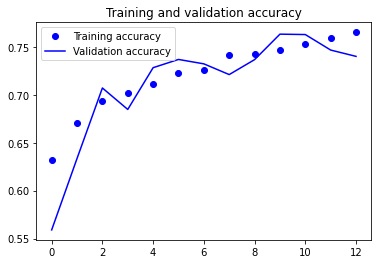

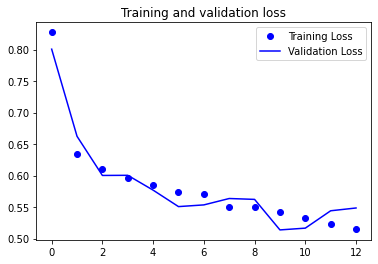

In [27]:
plot_loss_accuracy(history)

Можно отметить что сеть обучается стабильно, без переобучения. благодаря параметру Dropout = 0.5, но очень медленно. 

Воспользуемся предобученной сетью.—

## Моделирование на основе предобученной сети VGG

Импортируем эту модель

In [9]:
from keras.applications.vgg16 import VGG16

Загружаем предобученную модель

In [10]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

58900480/58889256 [==============================] - 0s 0us/step


фиксируем все веса предобученной сети и выводим ее структуру

In [11]:
#for layer in base_model.layers:
#    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Доработаем архитектуру под решаемую задачу бинарной классификации

In [12]:
model2 = Sequential()
model2.add(base_model)

model2.add(Flatten())

#model2.add(Dropout(0.5))

model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

Итоговая рхитектура модели

In [13]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


Компилируем модель и запускаем обучение

In [14]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_loss.h5',
                                       monitor='val_loss', save_best_only=True,
                                       save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
EPOCHS = 13 # количество эпох

# Функция потерь для обучения
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model2.compile(loss = 'binary_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy']
             )

In [ ]:
# model.fit_generator is deprecated, use fit
history2 = model2.fit(
            train_generator,
            steps_per_epoch = train_generator.samples / BATCH_SIZE, # train_generator.samples = 20000
            epochs = EPOCHS,
            validation_data = val_generator,
            validation_steps = val_generator.samples / BATCH_SIZE, # train_generator.samples = 5000
            callbacks=my_callbacks
            )

Epoch 1/13
200/200 [==============================] - 230s 1s/step - loss: 0.6343 - accuracy: 0.6324 - val_loss: 0.4997 - val_accuracy: 0.7478
Epoch 2/13
200/200 [==============================] - 221s 1s/step - loss: 0.4421 - accuracy: 0.7899 - val_loss: 0.3676 - val_accuracy: 0.8274
Epoch 3/13
200/200 [==============================] - 221s 1s/step - loss: 0.3332 - accuracy: 0.8539 - val_loss: 0.2591 - val_accuracy: 0.8876
Epoch 4/13
200/200 [==============================] - 221s 1s/step - loss: 0.2863 - accuracy: 0.8840 - val_loss: 0.2259 - val_accuracy: 0.9142
Epoch 5/13
200/200 [==============================] - 221s 1s/step - loss: 0.2317 - accuracy: 0.9040 - val_loss: 0.1581 - val_accuracy: 0.9378
Epoch 6/13
200/200 [==============================] - 221s 1s/step - loss: 0.2168 - accuracy: 0.9126 - val_loss: 0.1647 - val_accuracy: 0.9364
Epoch 7/13
200/200 [==============================] - 221s 1s/step - loss: 0.1834 - accuracy: 0.9246 - val_loss: 0.2450 - val_accuracy: 0.9072

In [ ]:
model2.save('/content/drive/MyDrive/dog_vs_cat_vgg16.h5')

Выведем историю обучения в графическом виде

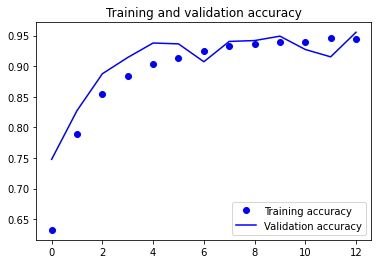

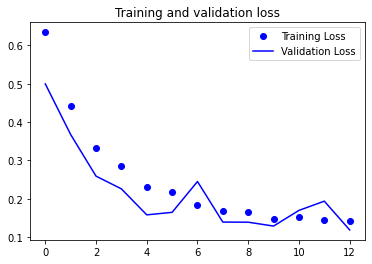

In [ ]:
plot_loss_accuracy(history2)

Можно отметить хорошую динамику обучения: устойчивое и синхронное снижение метрики Loss.

## Подготовка данных для сабмита

Необходимая для выполнения задания точность достигнута, выведем предсказания и сформируем загрузочный реестр для сабмита

In [9]:
from keras.preprocessing.image import load_img, img_to_array

In [16]:
model = keras.models.load_model('/content/drive/MyDrive/dog_vs_cat_vgg16.h5')

In [8]:
test_list = glob.glob('test/*.jpg')

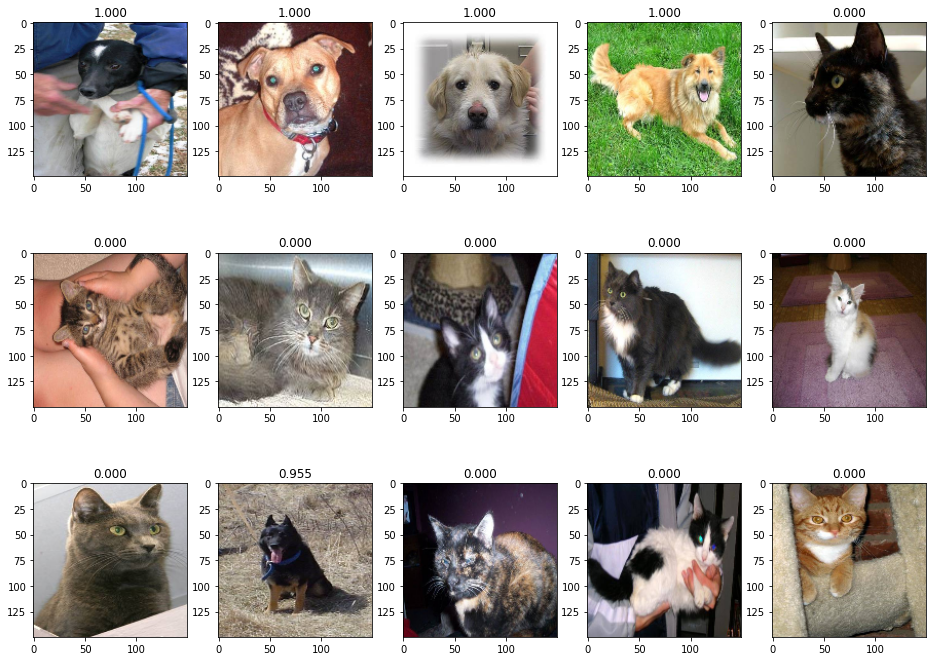

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 12))

for i, path in enumerate(test_list[:15], 1):
    subplot = fig.add_subplot(3, 5, i)

    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img);

    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
        
    result_predict = model.predict(x)
    score = result_predict[0][0]
    subplot.set_title('%.3f' % score);

Видно, что есть и неуверенные предсказания. и ошибки, но большая часть предсказана с хорошим значением score (ближе к нулю - кошка, к 1 - собака)

Формируем сабмит

In [6]:
model = keras.models.load_model('/content/drive/MyDrive/dog_vs_cat_vgg16_.h5')

In [10]:
from tqdm import tqdm
p = re.compile(r'\d+')

test_list = sorted(test_list, key = lambda s: int(p.search(s).group()))

with open('submit.csv', 'w') as f:
    f.write('id,label\n')
    
    for i, path in enumerate(tqdm(test_list), 1):
        img = load_img(path, target_size = IMG_SIZE)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        
        result_predict = model.predict(x)
        f.write(f'{i},{result_predict[0][0]}\n')

100%|██████████| 12500/12500 [54:11<00:00,  3.84it/s]


Результат на kaggle:

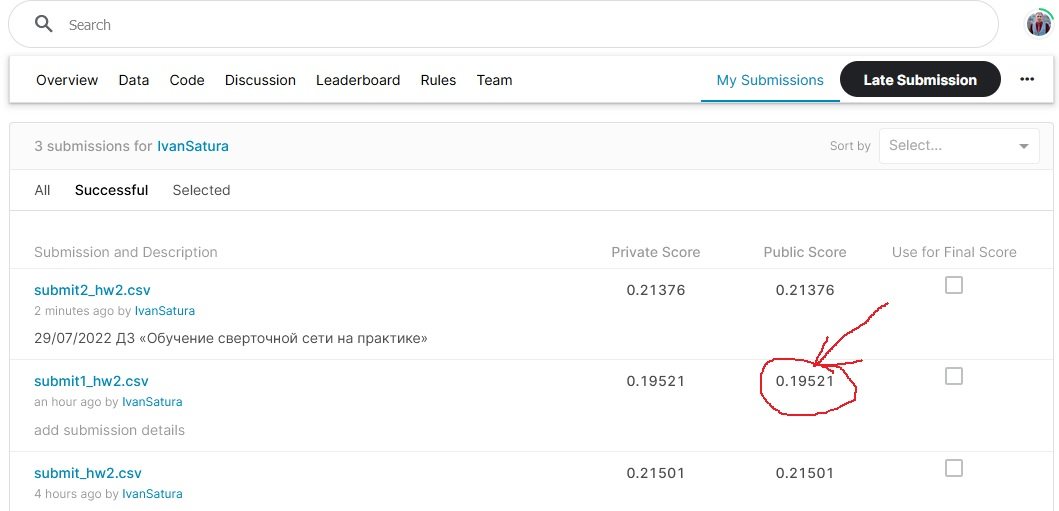

# Дообучение

In [30]:
del model2

In [31]:
model2 = keras.models.load_model('/content/drive/MyDrive/dog_vs_cat_vgg16.h5' )

In [32]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_loss.h5',
                                       monitor='val_loss', save_best_only=True,
                                       save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [37]:
EPOCHS = 10 # количество эпох

# Функция потерь для обучения
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

model2.compile(loss = 'binary_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy']
             )

In [38]:
# model.fit_generator is deprecated, use fit
history2 = model2.fit(
            train_generator,
            steps_per_epoch = train_generator.samples / BATCH_SIZE, # train_generator.samples = 20000
            epochs = EPOCHS,
            validation_data = val_generator,
            validation_steps = val_generator.samples / BATCH_SIZE, # train_generator.samples = 5000
            callbacks=my_callbacks
            )

Epoch 1/10
200/200 [==============================] - 224s 1s/step - loss: 0.0752 - accuracy: 0.9712 - val_loss: 0.1025 - val_accuracy: 0.9664
Epoch 2/10
200/200 [==============================] - 223s 1s/step - loss: 0.0614 - accuracy: 0.9779 - val_loss: 0.1325 - val_accuracy: 0.9666
Epoch 3/10
200/200 [==============================] - 222s 1s/step - loss: 0.0551 - accuracy: 0.9776 - val_loss: 0.1354 - val_accuracy: 0.9666
Epoch 4/10
200/200 [==============================] - 222s 1s/step - loss: 0.0530 - accuracy: 0.9802 - val_loss: 0.0901 - val_accuracy: 0.9686
Epoch 5/10
200/200 [==============================] - 222s 1s/step - loss: 0.0490 - accuracy: 0.9811 - val_loss: 0.1514 - val_accuracy: 0.9658
Epoch 6/10
200/200 [==============================] - 222s 1s/step - loss: 0.0489 - accuracy: 0.9812 - val_loss: 0.1458 - val_accuracy: 0.9672
Epoch 7/10
200/200 [==============================] - 221s 1s/step - loss: 0.0468 - accuracy: 0.9819 - val_loss: 0.1348 - val_accuracy: 0.9686

In [40]:
model2.save('/content/drive/MyDrive/dog_vs_cat_vgg16_.h5')